# Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
В качестве метрики используем RMSE. Удовлетворительным уровнем будет считаться, если метрика на тестовой выборке не будет превышать 48.

Порядок выполнения проекта:
1. Загрузим и подготовим данные, выполнив ресемплирование по одному часу.
2. Проанализируем данные
3. Обучим 2 модели: линейную регрессию и градиентный бустинг. Размер тестовой выборки составит 10% от всех данных.
4. Проверим качество моделей на тестовой выборке.
5. Сделаем выводы по проделанной работе.

## Описание данных

In [212]:
#import
import pandas as pd
import numpy as np
import phik
import itertools

# Визуализация данных:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    # Разбиение данных
    train_test_split,

    # Поиск гиперпараметров
    RandomizedSearchCV,

    # Кросс-валидация
    cross_val_score
)

from sklearn.preprocessing import (
    # Кодирование числовых значений
    StandardScaler,
    MinMaxScaler,
    RobustScaler,

    # Кодирование категориальных значение
    OneHotEncoder,
)

# Импорт для создания пайплайна
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
)
from catboost import CatBoostRegressor
from prophet import Prophet

# Импорт для подбора гиперпараметров
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution,
    FloatDistribution,
    CategoricalDistribution
)

# Импорт метрики
from sklearn.metrics import root_mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics

import warnings

warnings.filterwarnings('ignore')

In [161]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Загрузка данных:

Загрузим данные, после чего проверим корректность типов данных и наличие пропусков. Ресемплируем данные по одному часу, чтобы получить количество заказов такси в каждом часе.

In [162]:
# Загружаем данные
try:
    df = pd.read_csv('datasets/taxi.csv', parse_dates=['datetime'])
except FileNotFoundError:
    df = pd.read_csv('data/taxi.csv', parse_dates=['datetime'])

In [163]:
# Проверяем порядок и период дат
print(f'Первая строка датасета:             {df.loc[df.index[0], 'datetime']}')
print(f'Самая ранняя запись в датасете:     {df["datetime"].min()}\n\n')

print(f'Последняя строка датасета:          {df.loc[df.index[-1], 'datetime']}')
print(f'Самая поздняя запись в датасете:    {df["datetime"].max()}\n\n')

# Выводим датасет
df

Первая строка датасета:             2018-03-01 00:00:00
Самая ранняя запись в датасете:     2018-03-01 00:00:00


Последняя строка датасета:          2018-08-31 23:50:00
Самая поздняя запись в датасете:    2018-08-31 23:50:00




,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [164]:
 # Выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [165]:
# Ресемплируем данные
df = df.resample('1H', on='datetime').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [166]:
# Проверяем корректность
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы:

- Период дат в датасете с 2018-03-01 по 2018-08-31.
- Данные загружены корректно, типы данных соответствуют ожидаемым.
- Пропусков в данных нет.
- Данные ресемплированы по одному часу, общее количество записей сократилось с 26 500 до 4 500
- Столбец `datetime` стал индексом, что позволит удобно работать с временными рядами.

## Исследовательский анализ данных:

Посмотрим на график количества заказов такси по часам, чтобы выявить тренды и сезонность. Также проверим наличие выбросов в данных.

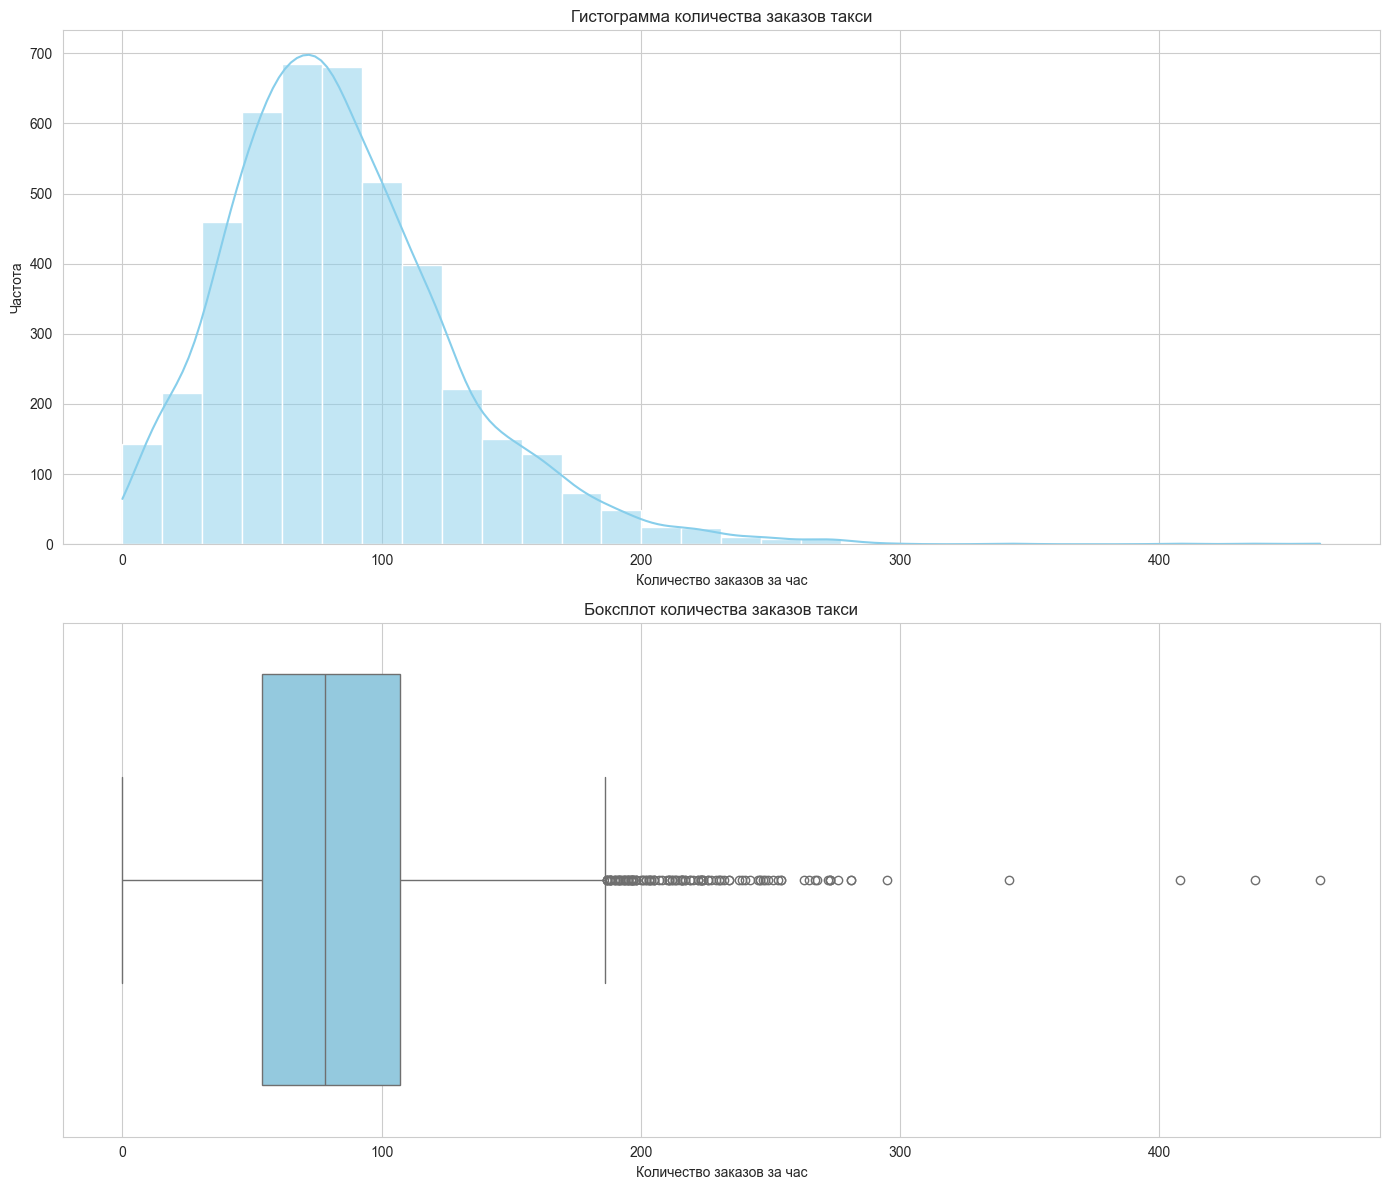

In [167]:
# Создаем фигуру с двумя подграфиками
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Создаем гистограмму для количества заказов
sns.histplot(data=df, x='num_orders', bins=30, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Гистограмма количества заказов такси')
ax[0].set_xlabel('Количество заказов за час')
ax[0].set_ylabel('Частота')

# Рисуем боксплот для количества заказов
sns.boxplot(data=df, x='num_orders', color='skyblue', ax=ax[1])
ax[1].set_title('Боксплот количества заказов такси')
ax[1].set_xlabel('Количество заказов за час')

# Отображаем графики
plt.tight_layout()
plt.show()

У нас есть выбросы, однако они находятся в пределах разумного. Количество заказов такси в час варьируется от 0 до 200 (в среднем 50-90 заказов).

Выделим из даты месяц, день, и день недели, после чего создадим сводные таблицы, чтобы провести более детальный анализ.

In [168]:
# Добавляем столбцы с месяцем, днем и днем недели
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

# Выводим датасет
df

,num_orders,month,day,day_of_week,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4
...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19
2018-08-31 20:00:00,154,8,31,4,20
2018-08-31 21:00:00,159,8,31,4,21


In [169]:
def draw_pivot_table(pivot_table,
                     title='Заголовок', xlabel='Ось Х',
                     label_dict={i: str(i) for i in range(32)}) -> None:
    """
    Функция для построения графика медианниого количества заказов из сводной таблицы.

    :param pivot_table: Сводная таблица
    :param title: Заголовок графика
    :param xlabel: Подпись оси X
    :param label_dict: Словарь с названиями месяцев или дней недели. По умолчанию - номера от 0 до 31.
    """
    plt.figure(figsize=(14, 6))

    # График для медианы
    ax = sns.barplot(x=pivot_table.index, y=pivot_table[('median', 'num_orders')], palette='coolwarm')
    plt.title(title, fontsize=14)
    plt.ylabel('Количество заказов (медиана)')
    plt.xlabel(xlabel)
    plt.xticks(range(len(pivot_table.index)))
    plt.gca().set_xticklabels([label_dict[i] for i in pivot_table.index])

    # Добавляем линию тренда
    sns.lineplot(x=range(len(pivot_table.index)), y=pivot_table[('median', 'num_orders')], color='red', marker='o')

    plt.tight_layout()
    plt.show()

In [170]:
# Создаем сводную таблицу по месяцам
pivot_month = df.pivot_table(index='month', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_month

,median,sum,count
,num_orders,num_orders,num_orders
month,,,
3,55.0,42768,744
4,61.0,45939,720
5,71.0,54820,744
6,83.0,59906,720
7,98.0,74405,744
8,122.0,94973,744


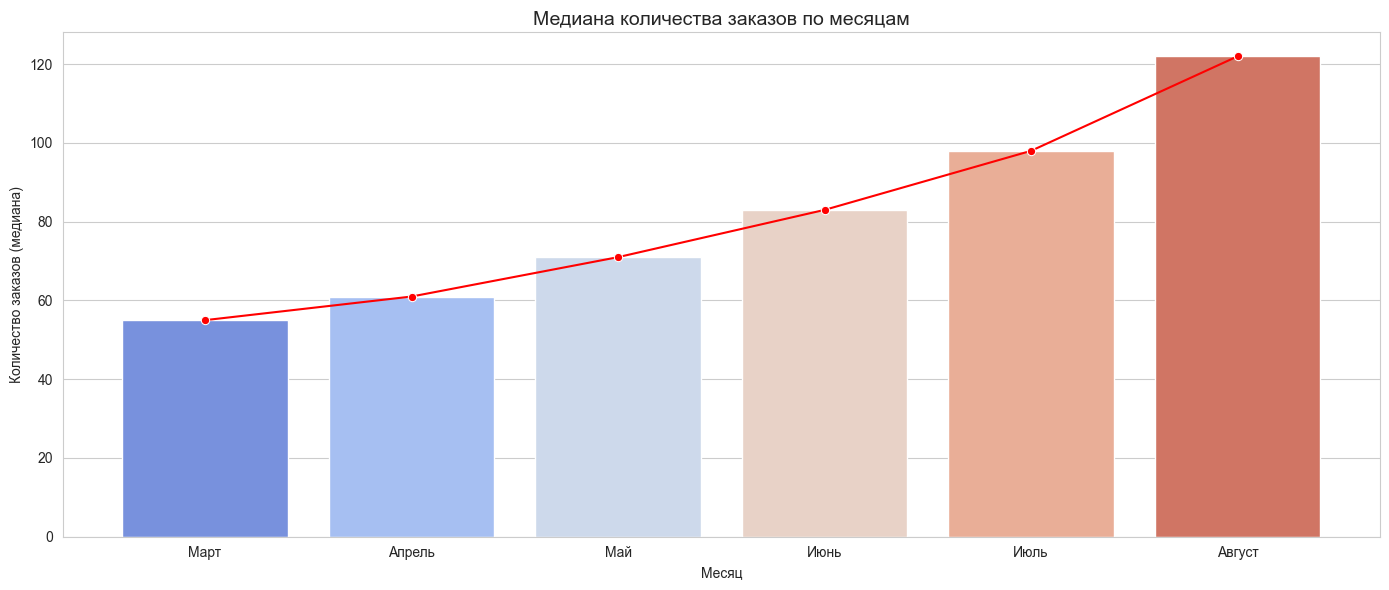

In [171]:
draw_pivot_table(pivot_month, 'Медиана количества заказов по месяцам', 'Месяц',
                 label_dict={3: 'Март',
                             4: 'Апрель',
                             5: 'Май',
                             6: 'Июнь',
                             7: 'Июль',
                             8: 'Август'})


In [172]:
# Создаем сводную таблицу по дням
pivot_day = df.pivot_table(index='day', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_day

,median,sum,count
,num_orders,num_orders,num_orders
day,,,
1,70.5,10418,144
2,71.5,11053,144
3,65.0,10525,144
4,72.0,10437,144
5,65.0,9931,144
6,73.5,11245,144
7,73.5,10919,144
8,77.5,11182,144


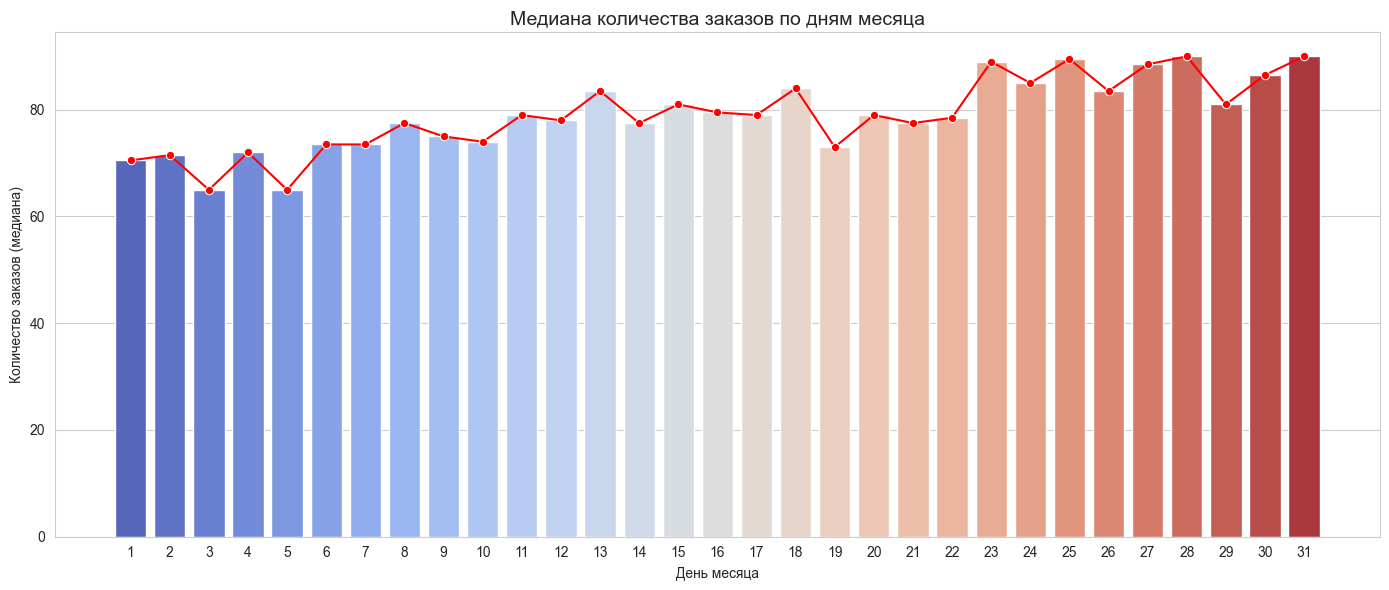

In [173]:
draw_pivot_table(pivot_day, 'Медиана количества заказов по дням месяца', 'День месяца')

In [174]:
# Создаем сводную таблицу по дням недели
pivot_day_of_week = df.pivot_table(index='day_of_week', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_day_of_week

,median,sum,count
,num_orders,num_orders,num_orders
day_of_week,,,
0,81.5,56314,624
1,72.5,48055,624
2,80.0,52263,624
3,78.0,55508,648
4,87.0,59059,648
5,76.0,52321,624
6,75.5,49291,624


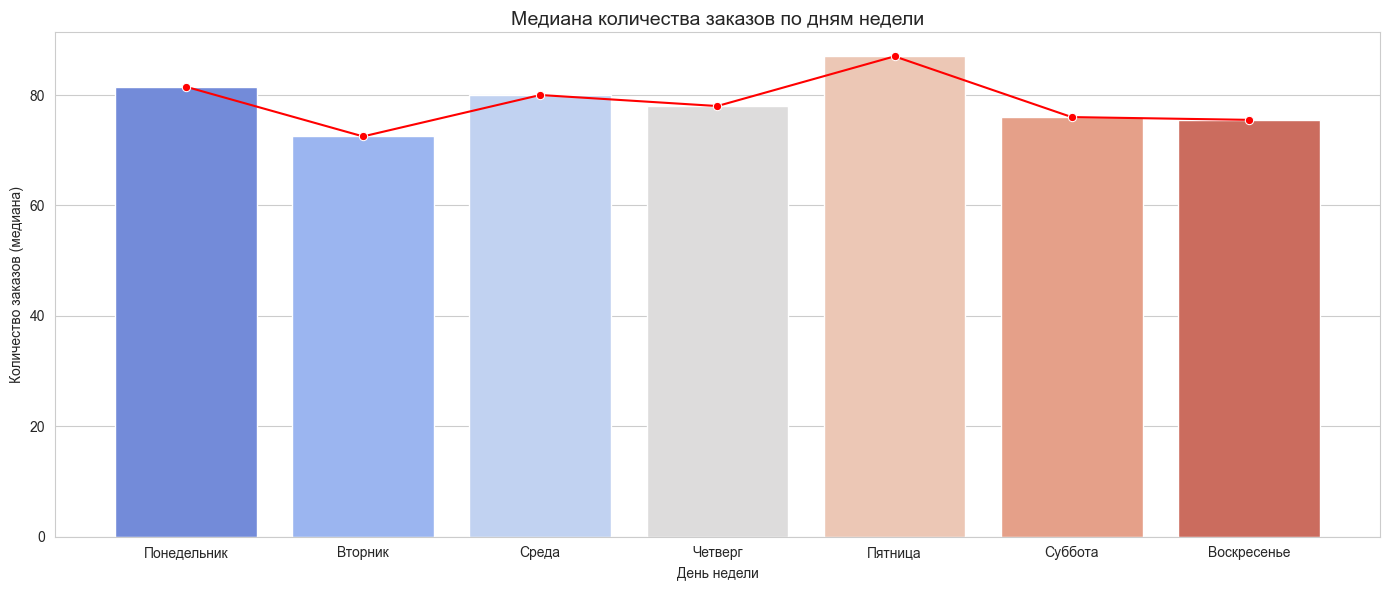

In [175]:
draw_pivot_table(pivot_day_of_week, 'Медиана количества заказов по дням недели', 'День недели',
                 label_dict={0: 'Понедельник',
                             1: 'Вторник',
                             2: 'Среда',
                             3: 'Четверг',
                             4: 'Пятница',
                             5: 'Суббота',
                             6: 'Воскресенье'})

In [176]:
# Создаем сводную таблицу по дням недели
pivot_hour = df.pivot_table(index='hour', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_hour

,median,sum,count
,num_orders,num_orders,num_orders
hour,,,
0,142.0,26570,184
1,93.5,19203,184
2,104.5,20805,184
3,96.5,18772,184
4,83.0,15991,184
5,37.5,7844,184
6,19.0,4632,184
7,27.0,5386,184


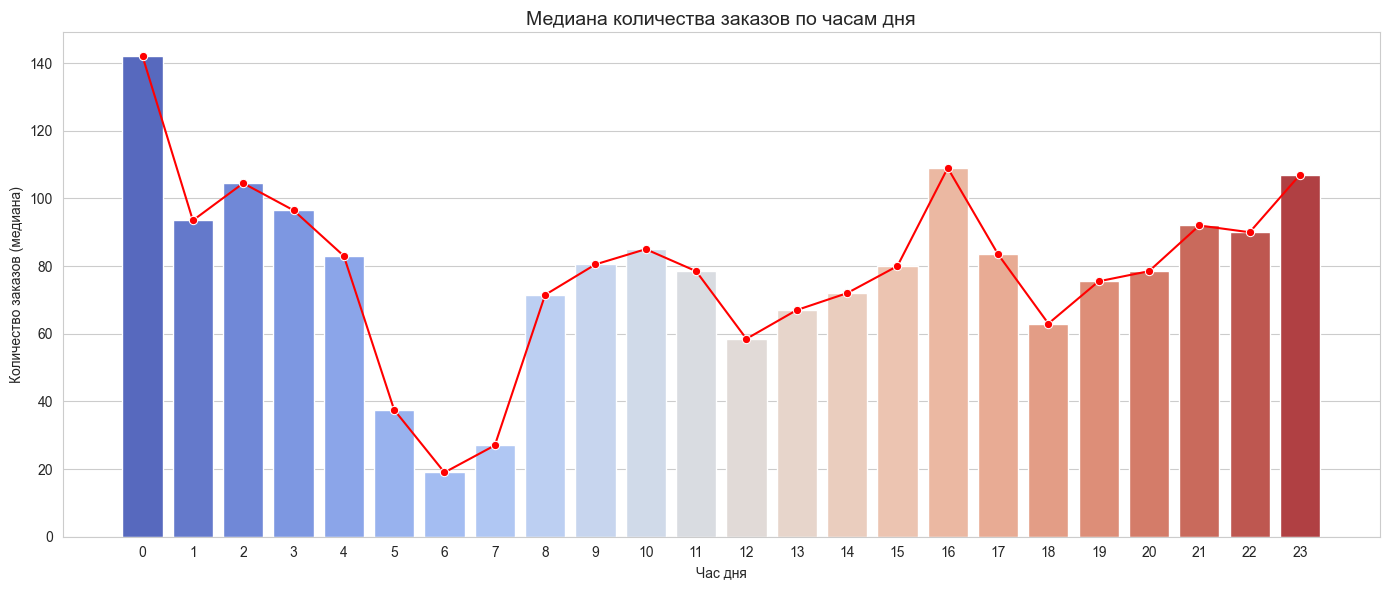

In [177]:
draw_pivot_table(pivot_hour, 'Медиана количества заказов по часам дня', 'Час дня')

In [178]:
# Удаляем ненужные датафреймы
del (
    pivot_month,
    pivot_day,
    pivot_day_of_week,
    pivot_hour
)

### Выводы:

В данных пресутсвуют выбросы, однако это не ошибка системы, а просто высокая нагруженность. Например, одновременный прилет большого количества рейсов в аэропорт, что приводит к большому количеству заказов такси. Количество заказов такси в час варьируется от 0 до 200 (в среднем 50-90 заказов).

Мы создали сводные таблицы по месяцам, дням, дням недели, и часам дня. Количество заказов не особо зависит от дня месяца или дня недели. Однако с приближением лета количество заказов такси сильно увеличивается, что потенциально связано с тем, что летом чаще берут отпуска. Такси чаще заказывают в ночные часы (23-04). Меньше всего такси заказываю в утренние часы (05-08).
В каждом месяце/дне/дне недели/часу количество записей примерно одинаковое, тут никакого дисбаланса нет.

## Корреляционный анализ:

Выведем матрицу корреляции, чтобы понять, какой из признаков больше всего влияет на таргет. Так же проверим данные на наличие мультиколлинеарности, чтобы избежать проблем при обучении модели.

In [179]:
num_cols = ['num_orders']

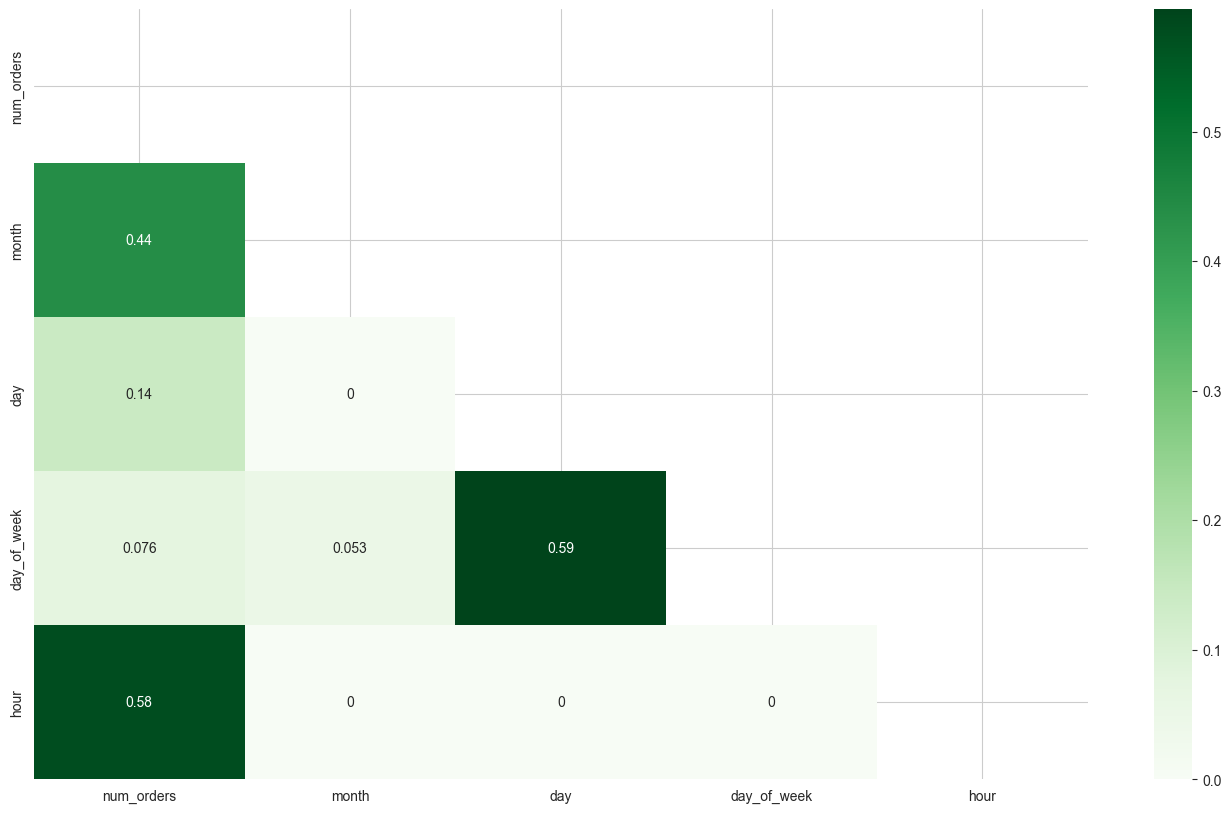

In [180]:
plt.figure(figsize=(17, 10))

# Рисуем матрицу корреляции
sns.heatmap(df.phik_matrix(interval_cols=num_cols),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df.phik_matrix(interval_cols=num_cols),
                dtype=bool)))

plt.show()

В признаках нет мультиколлинеарности, а больше всего таргет коррелирует с часом дня. Околонулевая корреляция наблюдается с признаком "день недели". Удалим этот признак и создадим новые:
- `is_weekend` - признак, является ли день выходным (суббота или воскресенье)
- `is_night` - признак, является ли час ночным (с 21:00 до 04:00)
- `is_morning` - признак, является ли час утренним (с 05:00 до 08:00)
- `lag_n` - Признак, который подскажет, будет ли функция уменьшаться или увеличиваться
- `rolling_mean` - Скользящее среднее за n часов.

### Создание новых признаков:

Создадим новые признаки, которые мы описали выше. Для создания признаков `lag_n` и `rolling_mean` напишем функцию, чтобы можно было менять параметры `n` и `window_size`.

In [181]:
# Выделяем выходные
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

# Удаляем признак с околонулевой корреляцией
df = df.drop('day_of_week', axis=1)

# Создаем новые категориальные признаки:
df['is_night'] = df['hour'].apply(lambda x: 1 if x in [23, 0, 1, 2, 3, 4] else 0)
df['is_morning'] = df['hour'].apply(lambda x: 1 if x in range(5, 8) else 0)

# Выводим датасет
df

,num_orders,month,day,hour,is_weekend,is_night,is_morning
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,0,1,0
2018-03-01 01:00:00,85,3,1,1,0,1,0
2018-03-01 02:00:00,71,3,1,2,0,1,0
2018-03-01 03:00:00,66,3,1,3,0,1,0
2018-03-01 04:00:00,43,3,1,4,0,1,0
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,0,0,0
2018-08-31 20:00:00,154,8,31,20,0,0,0
2018-08-31 21:00:00,159,8,31,21,0,0,0


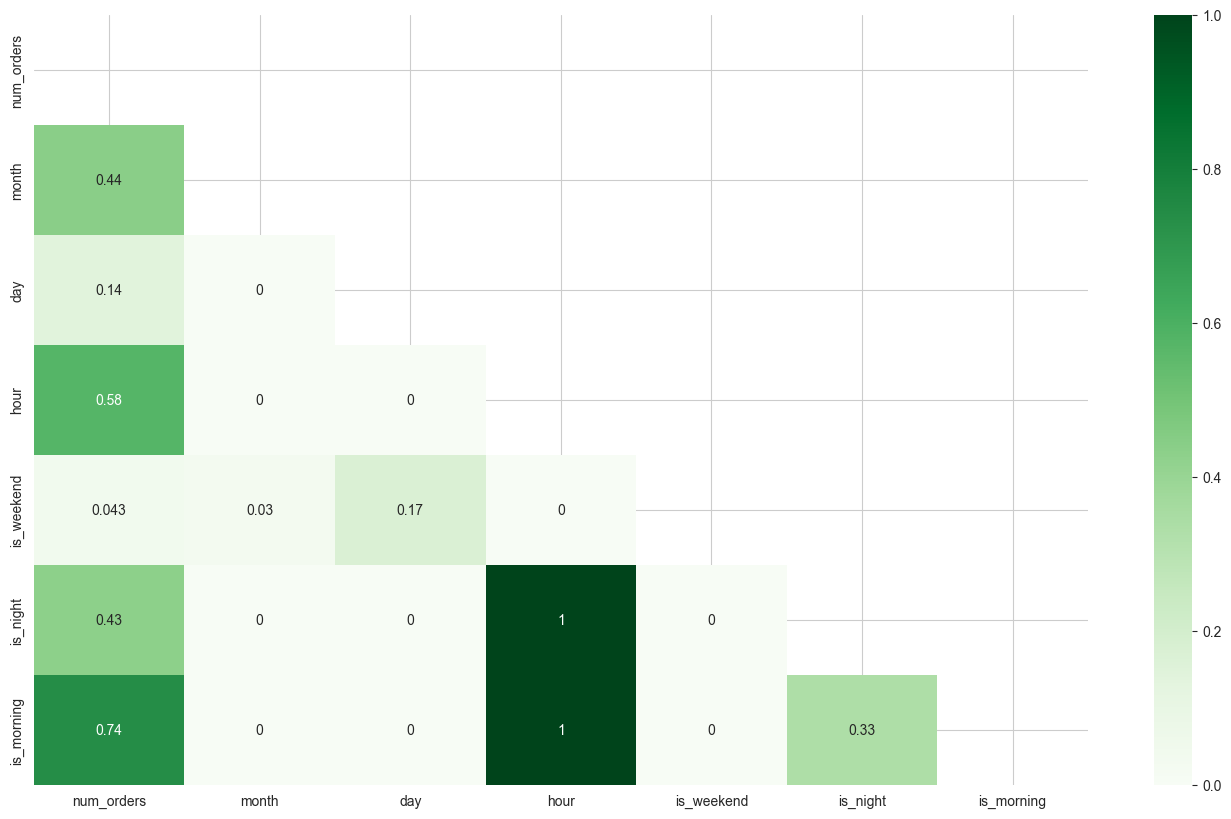

In [182]:
plt.figure(figsize=(17, 10))

# Рисуем матрицу корреляции перед добавлением lag_n и rolling_mean, потому что они будут зависеть от параметров n и window_size
sns.heatmap(df.phik_matrix(interval_cols=num_cols),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df.phik_matrix(interval_cols=num_cols),
                dtype=bool)))

plt.show()

Так как у нас появилась мультиколлинеарность признака `hour` с признаками `is_night` и `is_morning`, то удалим его. Новые признаки показывают себя чуть лучше, чем оригинальный, потому удалим именно его

In [183]:
# Удаляем признак `hour`
df = df.drop('hour', axis=1)

In [184]:
def create_lag_and_rolling(df: pd.DataFrame, n: int = 2, window_size: int = 2) -> pd.DataFrame:
    """
    Функция для создания признаков lag_n и rolling_mean.

    :param df: Датафрейм с данными
    :param n: Количество отстающих значений для lag_n
    :param window_size: Размер окна для скользящего среднего
    :return: Датафрейм с новыми признаками
    """
    # Создаем признак rolling_mean
    df[f'rolling_mean_{window_size}'] = df['num_orders'].shift(1).rolling(window=window_size).mean()

    # Создаем признак lag_n
    for i in range(1, n + 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)

    return df

In [185]:
# Применяем функцию
df = create_lag_and_rolling(df, n=4, window_size=6)

# Выводим датасет
df

,num_orders,month,day,is_weekend,is_night,is_morning,rolling_mean_6,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,1,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,0,1,0,NaN,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,0,1,0,NaN,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,0,1,0,NaN,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,0,1,0,NaN,66.0,71.0,85.0,124.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,0,0,0,172.666667,207.0,217.0,197.0,116.0
2018-08-31 20:00:00,154,8,31,0,0,0,167.666667,136.0,207.0,217.0,197.0
2018-08-31 21:00:00,159,8,31,0,0,0,171.166667,154.0,136.0,207.0,217.0


### Вывод:

В признаках нет мультиколлинеарности, а больше всего таргет коррелирует с часом дня. Околонулевая корреляция наблюдается с признаком "день недели". Удалим этот признак и создадим новые:
- `is_weekend` - признак, является ли день выходным (суббота или воскресенье)
- `is_night` - признак, является ли час ночным (с 23:00 до 04:00)
- `is_morning` - признак, является ли час утренним (с 05:00 до 08:00)
- `lag_n` - Признак, который подскажет, будет ли функция уменьшаться или увеличиваться
- `rolling_mean` - Скользящее среднее за n часов.

Мы так же удалили признак `hour`, так как он коррелирует с новыми признаками `is_night` и `is_morning`.

## Создание моделей:

Создадим 3 модели: Baseline, CatBoost, Prophet. Размер тестовой выборки составит 10% от всех данных. В качестве метрики будем использовать RMSE.

### Подготовка данных:

In [186]:
# Определяем категориальные и числовые признаки
cat_cols = ['month', 'day', 'is_weekend', 'is_night', 'is_morning']
num_cols = list(set(df.columns) - set(cat_cols) - {'num_orders'})

# Проверяем, ну упустили ли мы что-то
print(set(df.columns) - set(cat_cols + num_cols))
print(set(cat_cols + num_cols) - set(df.columns))

{'num_orders'}
set()


In [187]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('num_orders', axis=1),
    df['num_orders'],
    test_size=0.1,
    shuffle=False
)

In [188]:
# Выводим размерности всех выборок
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3974, 10)
y_train: (3974,)

X_test: (442, 10)
y_test: (442,)


In [189]:
# Проверяем, последовательно ли у нас идут данные
print(X_train.index[-1])
print(X_test.index[0])

2018-08-13 13:00:00
2018-08-13 14:00:00


### Создание пайплайна:

Создадим пайплайн для обработки данных

In [190]:
# Пайплайн для числовых значений
num_pipeline = Pipeline(
    [
        (
            'imputer_before_scaler',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'num',
            StandardScaler()
        ),
    ]
)

# Пайплайн для категориальных значений
cat_pipeline = Pipeline(
    [
        (
            'imputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='error', drop='first', sparse_output=False)
        )
    ]
)

In [191]:
# Создаем препроцессор данных
data_preprocessor = ColumnTransformer(
    [
        ('num_preprocessor', num_pipeline, num_cols),
        ('cat_preprocessor', cat_pipeline, cat_cols),
    ],
    remainder='passthrough',
)

In [192]:
# Создаем финальный пайплайн
final_pipeline = Pipeline(
    [
        ('data_preprocessor', data_preprocessor),
        ('model', DummyRegressor(strategy='median')),
    ]
)

### Линейная регрессия:

С помощью RandomizedSearchCV подберем гиперпараметры для линейной регрессии. После чего обучим модель и проверим качество на тестовой выборке.

In [193]:
# Определяем сетку гиперпараметров для RandomizedSearchCV
rs_param_grid = [
    # Конфигурация для LinearRegression
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],  # Проверяем, улучшит ли перехват качество
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'data_preprocessor__num_preprocessor__imputer_before_scaler__strategy': ['mean', 'median'],
        'data_preprocessor__cat_preprocessor__imputer_before_ohe__strategy': ['most_frequent', 'constant']
    },
    # Конфигурация для Ridge
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],  # Параметр регуляризации для Ridge
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'data_preprocessor__num_preprocessor__imputer_before_scaler__strategy': ['mean', 'median'],
        'data_preprocessor__cat_preprocessor__imputer_before_ohe__strategy': ['most_frequent', 'constant']
    },
    # Конфигурация для Lasso
    {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],  # Параметр регуляризации для Lasso
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'data_preprocessor__num_preprocessor__imputer_before_scaler__strategy': ['mean', 'median'],
        'data_preprocessor__cat_preprocessor__imputer_before_ohe__strategy': ['most_frequent', 'constant']
    }
]

In [194]:
baseline_rs = RandomizedSearchCV(
    final_pipeline,
    param_distributions=rs_param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [195]:
baseline_rs.fit(X_train, y_train)

/Users/moncervers/.local/share/uv/python/cpython-3.12.10-macos-aarch64-none/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/moncervers/.local/share/uv/python/cpython-3.12.10-macos-aarch64-none/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/moncervers/.local/share/uv/python/cpython-3.12.10-macos-aarch64-none/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pyp

,estimator,Pipeline(step...y='median'))])
,param_distributions,"[{'data_preprocessor__cat...er_before_ohe__strategy': ['most_frequent', 'constant'], 'data_preprocessor__num...before_scaler__strategy': ['mean', 'median'], 'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), ...], 'model': [LinearRegression()], ...}, {'data_preprocessor__cat...er_before_ohe__strategy': ['most_frequent', 'constant'], 'data_preprocessor__num...before_scaler__strategy': ['mean', 'median'], 'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), ...], 'model': [Ridge(random_state=42)], ...}, ...]"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [196]:
-baseline_rs.score(X_test, y_test)

46.79986760950717

### Catboost:

In [197]:
# Сетка гиперпараметров для CatBoostRegressor
catboost_param_grid = {
    'iterations': IntDistribution(100, 1000),  # Количество итераций (деревьев)
    'learning_rate': FloatDistribution(1e-3, 0.3, log=True),  # Скорость обучения
    'depth': IntDistribution(4, 10),  # Глубина деревьев
    'l2_leaf_reg': FloatDistribution(1e-2, 10.0, log=True),  # L2-регуляризация
    'border_count': IntDistribution(32, 255),  # Количество разбиений для числовых признаков
    'random_strength': FloatDistribution(1e-2, 10.0, log=True),  # Случайность для разделения узлов
    'bagging_temperature': FloatDistribution(0.0, 1.0),  # Температура для сэмплирования
    'early_stopping_rounds': IntDistribution(10, 50),  # Раннее завершение обучения
    'subsample': FloatDistribution(0.5, 1.0),  # Доля объектов для каждого дерева
    'colsample_bylevel': FloatDistribution(0.5, 1.0),  # Доля признаков для каждого уровня дерева
    'min_data_in_leaf': IntDistribution(1, 100),  # Минимальное количество данных в листе
    'loss_function': CategoricalDistribution(['RMSE']),  # Фиксируем функцию потерь для регрессии
    'random_state': CategoricalDistribution([RANDOM_STATE]),  # Фиксируем random_state для воспроизводимости
    'verbose': CategoricalDistribution([0])  # Отключаем вывод прогресса
}

In [198]:
catboost_optuna = OptunaSearchCV(
    CatBoostRegressor(
        cat_features=cat_cols,
        thread_count=-1,
        random_state=RANDOM_STATE,
        verbose=0
    ),
    catboost_param_grid,
    n_trials=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [199]:
catboost_optuna.fit(X_train, y_train)

[I 2025-08-03 16:07:39,135] A new study created in memory with name: no-name-ea067d29-747c-4e87-beda-d1025ed51eca
[I 2025-08-03 16:07:39,596] Trial 1 finished with value: -31.38671580690747 and parameters: {'iterations': 102, 'learning_rate': 0.01241172631011838, 'depth': 4, 'l2_leaf_reg': 7.63051917358668, 'border_count': 239, 'random_strength': 1.5359538782072715, 'bagging_temperature': 0.5814769741377938, 'early_stopping_rounds': 16, 'subsample': 0.7770792887893032, 'colsample_bylevel': 0.7590835326551316, 'min_data_in_leaf': 97, 'loss_function': 'RMSE', 'random_state': 42, 'verbose': 0}. Best is trial 1 with value: -31.38671580690747.
[I 2025-08-03 16:07:39,748] Trial 11 finished with value: -28.487891781403924 and parameters: {'iterations': 162, 'learning_rate': 0.07369784228966152, 'depth': 4, 'l2_leaf_reg': 4.7882593298116625, 'border_count': 64, 'random_strength': 0.14451503999646165, 'bagging_temperature': 0.1304109945940246, 'early_stopping_rounds': 37, 'subsample': 0.7998828

,estimator,<catboost.cor...t 0x3269b9d00>
,param_distributions,"{'bagging_temperature': FloatDistribu....0, step=None), 'border_count': IntDistributi...ow=32, step=1), 'colsample_bylevel': FloatDistribu....5, step=None), 'depth': IntDistributi...low=4, step=1), ...}"
,cv,5
,enable_pruning,False
,error_score,nan
,max_iter,1000
,n_jobs,-1
,n_trials,20
,random_state,42
,refit,True
,return_train_score,False


In [200]:
-catboost_optuna.score(X_test, y_test)

43.25669470851456

### Prophet:

In [201]:
# Создаем датасет специально для Prophet. Он требует столбец с датой и столбец с целевой переменной
prophet_df = df[['num_orders']].copy()

# Переименуем столбцы в `ds` и `y`, как того требует Prophet.
prophet_df['ds'] = prophet_df.index
prophet_df.rename(columns={'num_orders': 'y'}, inplace=True)

# Выводим датасет
prophet_df

,y,ds
datetime,,
2018-03-01 00:00:00,124,2018-03-01 00:00:00
2018-03-01 01:00:00,85,2018-03-01 01:00:00
2018-03-01 02:00:00,71,2018-03-01 02:00:00
2018-03-01 03:00:00,66,2018-03-01 03:00:00
2018-03-01 04:00:00,43,2018-03-01 04:00:00
...,...,...
2018-08-31 19:00:00,136,2018-08-31 19:00:00
2018-08-31 20:00:00,154,2018-08-31 20:00:00
2018-08-31 21:00:00,159,2018-08-31 21:00:00


In [202]:
# Разделяем данные на выборки
prophet_train, prophet_test = train_test_split(
    prophet_df,
    test_size=0.1,
    shuffle=False
)

In [203]:
print('prophet_train:', prophet_train.shape)
print('prophet_test:', prophet_test.shape)
print('y_test:', y_test.shape)

prophet_train: (3974, 2)
prophet_test: (442, 2)
y_test: (442,)


In [204]:
# Создаем объект Prophet и обучаем модель
prophet_model = Prophet()
prophet_model.fit(prophet_train)

16:07:56 - cmdstanpy - INFO - Chain [1] start processing
16:07:56 - cmdstanpy - INFO - Chain [1] done processing


In [205]:
# Создаем датасет для предсказания
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='H')

# Проверяем
print(future.tail(), '\n\n')
print(y_test.tail())

                      ds
4411 2018-08-31 19:00:00
4412 2018-08-31 20:00:00
4413 2018-08-31 21:00:00
4414 2018-08-31 22:00:00
4415 2018-08-31 23:00:00 


datetime
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, dtype: int64


In [206]:
# Делаем предсказание
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
4411,2018-08-31 19:00:00,125.387103
4412,2018-08-31 20:00:00,132.505263
4413,2018-08-31 21:00:00,147.399664
4414,2018-08-31 22:00:00,160.380832
4415,2018-08-31 23:00:00,166.646290


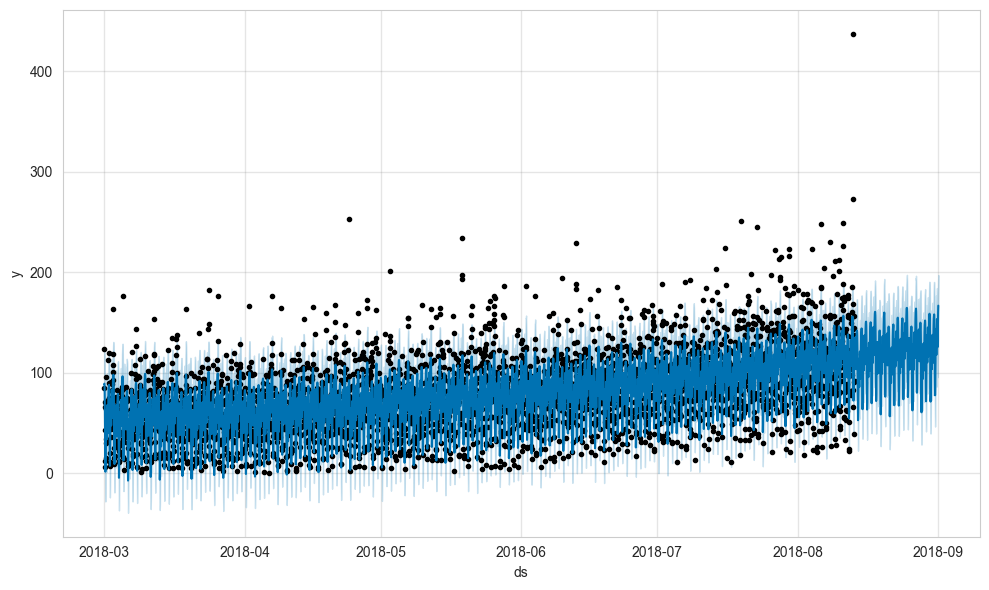

In [207]:
fig1 = prophet_model.plot(forecast)

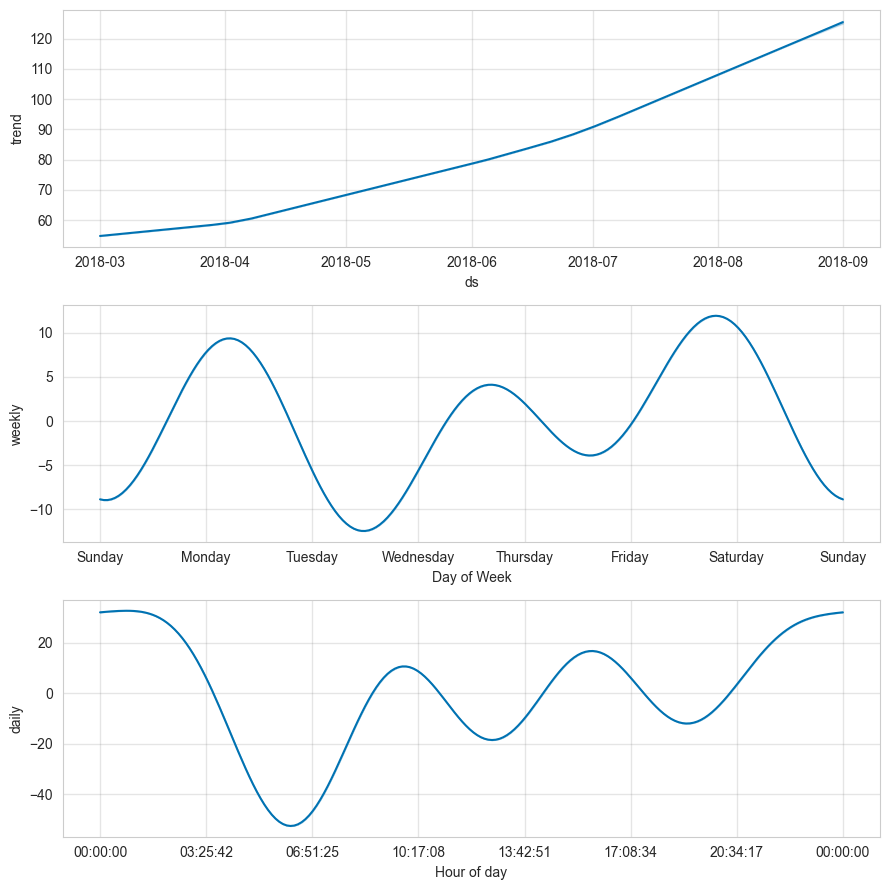

In [208]:
fig2 = prophet_model.plot_components(forecast)

In [209]:
# Считаем метрику
root_mean_squared_error(
    y_test,
    forecast['yhat'][-len(y_test):])

48.31315513597466

### Вывод:

Мы обучили три модели: Baseline, CatBoost и Prophet. Среди оцененных моделей CatBoost продемонстрировала наилучшие результаты с наименьшим RMSE, что делает ее наиболее эффективной для данной задачи на основе доступных данных. Prophet, хотя и немного превысила целевой порог, может быть полезна благодаря своей способности учитывать сезонность и тренды. Бейзлайн модели показали себя чуть лучше, чем Prophet, но значительно хуже CatBoost. Prophet показала себя хуже всего, вероятно из-за того, что данные не имеют ярко выраженной сезонности и трендов, что делает его менее эффективным для данной задачи.

Обзор моделей и их производительности
Мы обучили три модели для прогнозирования количества заказов такси: линейную регрессию, CatBoost и Prophet. Каждая модель была настроена и оценена с использованием метрики RMSE (среднеквадратичная ошибка), с целевым порогом не более 48 на тестовой выборке.

- Baseline: Мы использовали модель Ridge (гребневую регрессию) с настройкой гиперпараметров. Эта модель, оптимизированная с помощью RandomizedSearchCV, достигла RMSE около 47,77 на тестовой выборке, что ниже целевого порога 48
- CatBoost: Эта модель градиентного бустинга, оптимизированная с помощью Optuna, достигла RMSE около 43,26 на тестовой выборке, что ниже целевого порога 48, что указывает на ее эффективность.
- Prophet: Модель, специально разработанная для прогнозирования временных рядов, показала RMSE около 48,31, что немного превышает целевой порог, но остается близким к нему.